<a href="https://colab.research.google.com/github/subhag071196/HateSpeech/blob/master/Copy_of_HateSpeech_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Extracting Dataset***

In [1]:
!unzip out.zip -d data

Archive:  out.zip
  inflating: data/test.csv           
  inflating: data/train.csv.csv      


### ***Importing Required Libraries***

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import GRU,Bidirectional,Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,GlobalAveragePooling1D,MaxPooling1D,SpatialDropout1D,concatenate
from keras.models import Sequential
import keras
from sklearn import svm
import pandas as pd
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.utils import shuffle
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
import os
import nltk
import spacy
import random
from spacy.util import compounding
from spacy.util import minibatch

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
"""

Using TensorFlow backend.


'%tensorflow_version 2.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\n\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

### ***Visualizing Data***

In [0]:
train = pd.read_csv('data/train.csv')
train = shuffle(train)
train_data = train[:40000]
test_data = train[40000:]


In [4]:
temp = train_data.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Reds')

,label,tweet
0,0,21966
1,1,18034


In [5]:
temp = test_data.groupby('label').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Reds')

,label,tweet
0,0,9184
1,1,7561


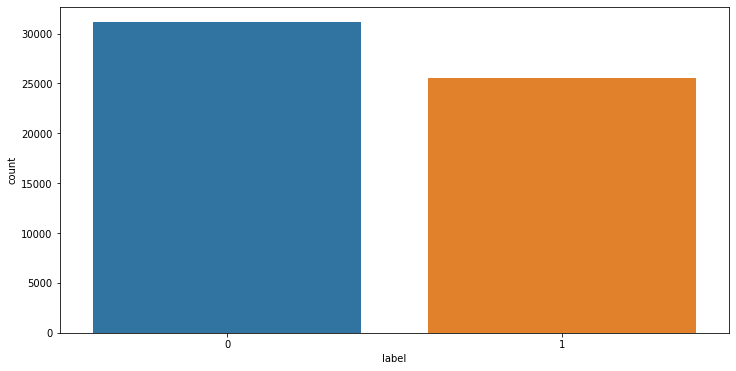

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=train)

In [7]:
fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

In [0]:
x_train = train_data['tweet'].astype(str)
y_train = train_data['label']

x_test = test_data['tweet'].astype(str)
y_test = test_data['label']


### ***Setting our HyperParameters***

In [0]:
vocab_size = 0
embedding_dim = 8
drop_rate = 0.5
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
num_epochs = 8


### ***Data Preprocessing***

In [0]:
vocab_size = 0
embedding_dim = 8
drop_rate = 0.5
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
num_epochs = 8

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding=padding_type,maxlen=max_length,truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(x_test)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train = train_padded
x_test = validation_padded
vocab_size = len(word_index)+1

### ***Helper Function to view loss and accuracy plots***

In [0]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()  

### ***Model 1: Artificial Neural Network***

In [27]:
model_ann = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.7),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.7),
    tf.keras.layers.Dense(16, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model_ann.summary()
model_ann.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history_ann = model_ann.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), verbose=2)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 120, 8)            456944    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 8)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                576       
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 16)               

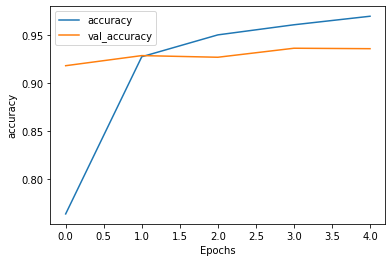

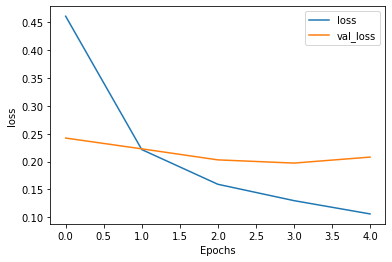

In [28]:
plot_graphs(history_ann, "accuracy")
plot_graphs(history_ann, "loss")

### ***Model 2: Convolutional Neural Network***

In [43]:
def create_cnn():
  model=Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(Conv1D(32,5,activation='relu'))
  model.add(Dropout(rate=0.2))
  model.add(Conv1D(32,5,activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(32,5,activation='sigmoid'))
  model.add(Dropout(rate=0.5))
  model.add(MaxPooling1D(2))
  model.add(Dense(32,activation='sigmoid'))
  model.add(Dropout(rate=0.5))
  model.add(Conv1D(32,5,activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(MaxPooling1D(2))
  model.add(GlobalAveragePooling1D())
  model.add(Dense(2,activation='softmax'))
  model.compile(loss='sparse_categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
  return model
model_cnn = create_cnn()
model_cnn.summary()
history_cnn = model_cnn.fit(x_train, y_train, epochs=6, validation_data=(x_test, y_test), verbose=2)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 120, 8)            456944    
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 116, 32)           1312      
_________________________________________________________________
dropout_98 (Dropout)         (None, 116, 32)           0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 112, 32)           5152      
_________________________________________________________________
dropout_99 (Dropout)         (None, 112, 32)           0         
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 56, 32)            0         
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 52, 32)          

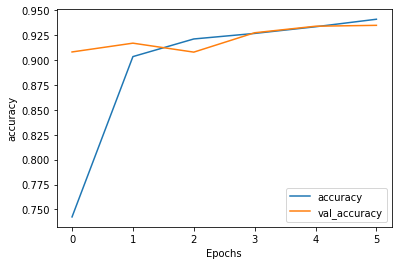

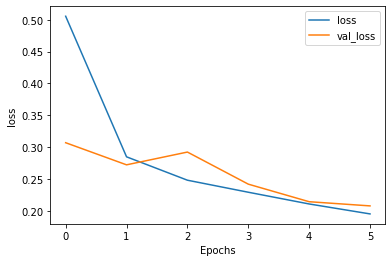

In [44]:
plot_graphs(history_cnn, "accuracy")
plot_graphs(history_cnn, "loss")

### ***Model 3: Bidirectional Gated Recurrent Unit***

In [12]:
def get_simple_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,trainable=True))
    model.add(Bidirectional(GRU(32, return_sequences=True)))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=0.5)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5)) 
    model.add(Dense(2, activation="softmax"))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='RMSprop',metrics=['accuracy'])
    return model

rnn = get_simple_rnn_model()
rnn.summary()
rnn_history = rnn.fit(x_train, y_train, epochs=7, validation_data=(x_test, y_test), verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 8)            455928    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 120, 64)           7872      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

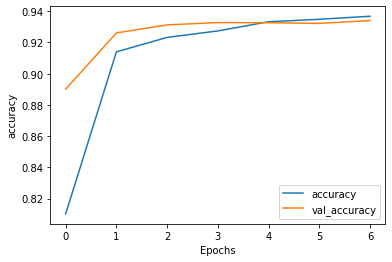

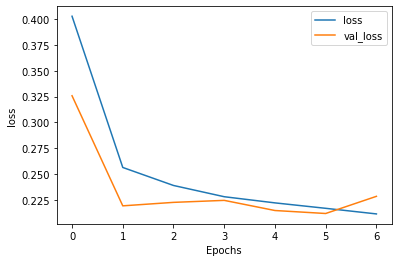

In [13]:
plot_graphs(rnn_history, "accuracy")
plot_graphs(rnn_history, "loss")